In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import optim
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable

from tabulate import tabulate
import tqdm

In [3]:
import json

with open('/content/drive/MyDrive/TCC/notebooks/Cifar10/analises/MLP/results_mlp.json') as f:
   results = json.load(f)
print(results)

{'adam': {'train_losses': [2.1062370693588255, 2.076851094207764, 2.0678223641967772, 2.0602485543060305, 2.0587779837799074, 2.0534436991119387, 2.048690745010376, 2.051316252593994, 2.0486506270980835, 2.0472399550628664, 2.0459978631591795, 2.0459018352508545, 2.041879363288879, 2.0415551443862916, 2.043610722885132, 2.0331813047790526, 2.037590685119629, 2.0437876927947998, 2.0348826806640625, 2.034775110015869, 2.0367631427764894, 2.035511237182617, 2.0313923596191406, 2.0278783959960935, 2.0293517457580568, 2.020473405380249, 2.025565743789673, 2.0230034784698487, 2.0239455332946776, 2.024515530090332, 2.0291555434417723, 2.0310216804504395, 2.0307760675811766, 2.024975893936157, 2.020272402267456, 2.029899219207764, 2.023634532852173, 2.0178457112121584, 2.019310655899048, 2.025860979309082, 2.020700854034424, 2.0217905261993407, 2.017151405105591, 2.021897798652649, 2.026359996948242, 2.0185883151245116, 2.016411352996826, 2.011942948150635, 2.0209782969665526, 2.02125450820922

# Analise dos resultados de treinamento



*   plots para loss






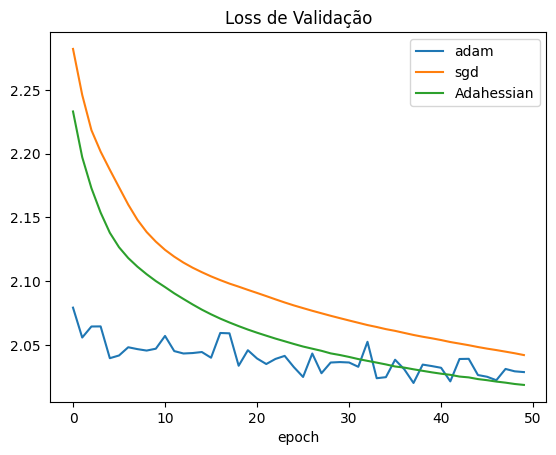

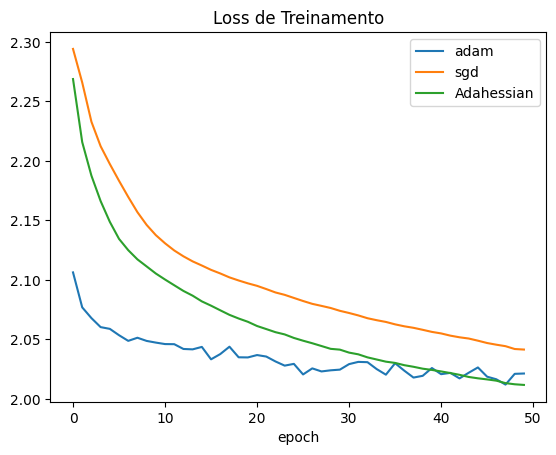

In [4]:
for optimizer, model_perform in results.items():
  for metric, values in model_perform.items():
    if metric == 'validation_losses':
      plt.title("Loss de Validação")
      plt.xlabel('epoch')
      plt.plot(values, label=optimizer)
      plt.legend(loc="upper right")

plt.show()


for optimizer, model_perform in results.items():
  for metric, values in model_perform.items():
    if metric == 'train_losses':
      plt.title('Loss de Treinamento')
      plt.xlabel('epoch')
      plt.plot(values, label=optimizer)
      plt.legend(loc="upper right")


plt.show()

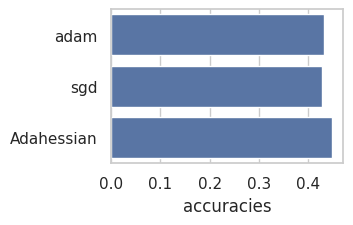

In [5]:
dic = {}
accuracies = np.array([results[key]['accuracy'] for key in results.keys()])
dic['accuracies'] = accuracies
df = pd.DataFrame(dic)

#compare models
plt.figure(figsize=(3, 2))
sns.set_theme(style="whitegrid")

ax = sns.barplot(y=results.keys(), x='accuracies', data=df)


In [6]:


# assign data

data = [[optimizer, results[optimizer]['accuracy']] for optimizer in results.keys() ]


# create header
head = ["Optimizer", "Accuracy"]

# display table
print(tabulate(data, headers=head, tablefmt="grid"))

+-------------+------------+
| Optimizer   |   Accuracy |
+=============+============+
| adam        |     0.4323 |
+-------------+------------+
| sgd         |     0.4271 |
+-------------+------------+
| Adahessian  |     0.4482 |
+-------------+------------+


# Predições dos modelos

carregar modelos

In [7]:

#DEFINIR MODELO

# Definir o Modelo
class SimpleMLP(nn.Module):
    def __init__(self, input_size=3*32*32, num_classes=10):
        super(SimpleMLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.25)
        )
        self.out = nn.Sequential(
            nn.Linear(512, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        output = self.out(x)
        return output


In [8]:
adahessian_cnn = SimpleMLP()
adahessian_cnn.load_state_dict(torch.load("/content/drive/MyDrive/TCC/notebooks/Cifar10/analises/MLP/adahessian_mlp_cifar10", map_location=torch.device('cpu')))
adahessian_cnn.eval()

SimpleMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
  )
  (out): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
    (1): Softmax(dim=1)
  )
)

In [9]:
adam_cnn = SimpleMLP()
adam_cnn.load_state_dict(torch.load("/content/drive/MyDrive/TCC/notebooks/Cifar10/analises/MLP/adam_mlp_cifar10", map_location=torch.device('cpu')))
adam_cnn.eval()

SimpleMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
  )
  (out): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
    (1): Softmax(dim=1)
  )
)

In [10]:
sgd_cnn = SimpleMLP()
sgd_cnn.load_state_dict(torch.load("/content/drive/MyDrive/TCC/notebooks/Cifar10/analises/MLP/sgd_mlp_cifar10", map_location=torch.device('cpu')))
sgd_cnn.eval()

SimpleMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
  )
  (out): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
    (1): Softmax(dim=1)
  )
)

carregar mnist

In [11]:
import torch
import torchvision
import torchvision.transforms as transforms

# Carregar e Pré-processar o CIFAR-10
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 72876244.54it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [12]:
loaders = {
    'train' : trainloader,

    'test'  : testloader
}

classificar os dados

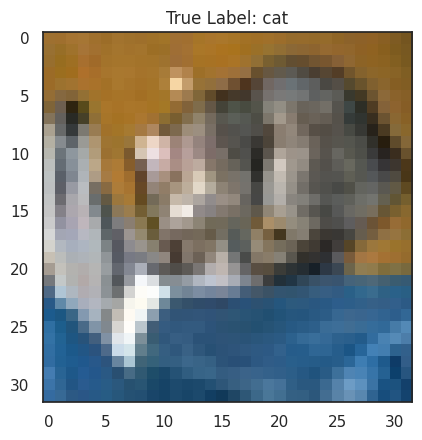

adam: cat
adahessian: car
sgd: car


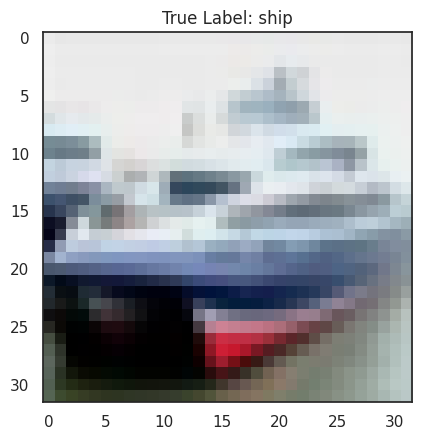

adam: ship
adahessian: truck
sgd: truck


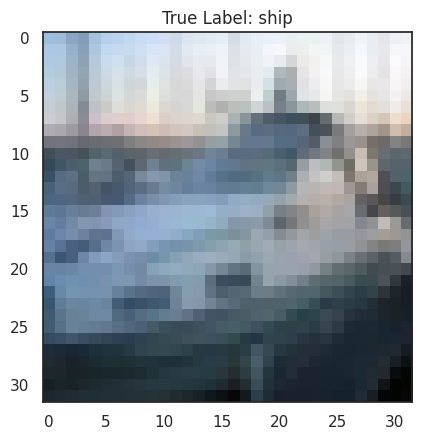

adam: ship
adahessian: ship
sgd: ship


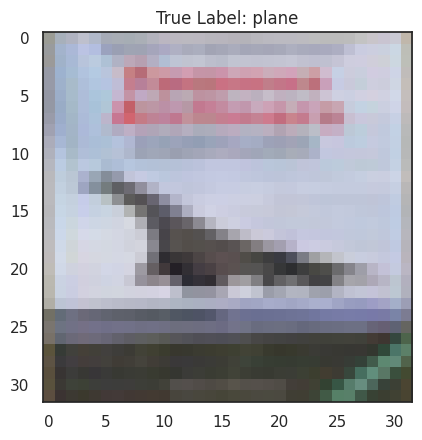

adam: ship
adahessian: ship
sgd: ship


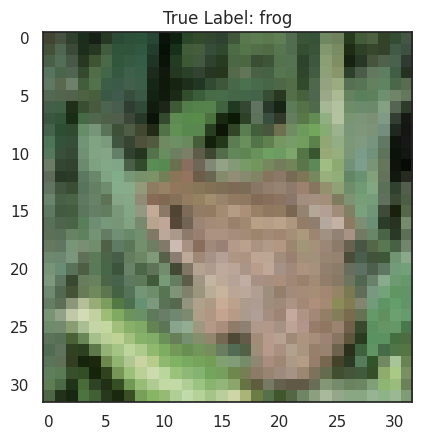

adam: deer
adahessian: deer
sgd: deer


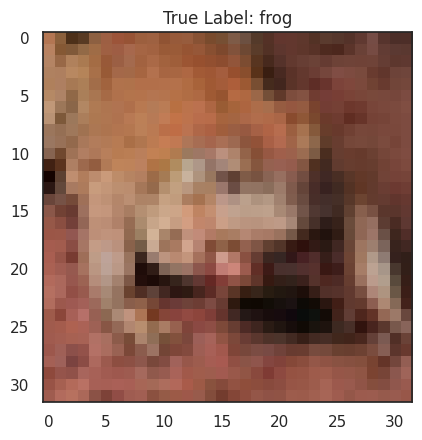

adam: frog
adahessian: frog
sgd: frog


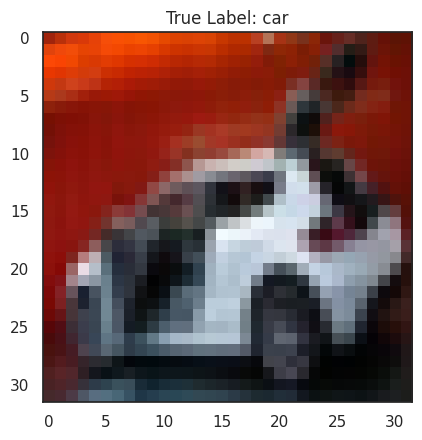

adam: cat
adahessian: cat
sgd: dog


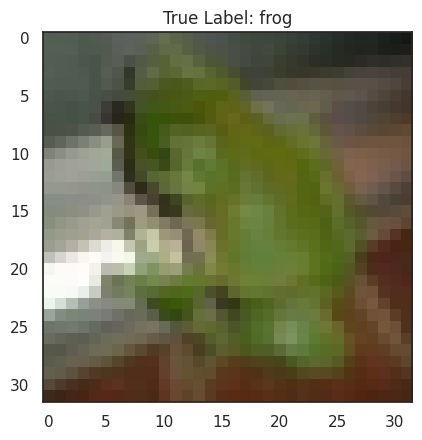

adam: deer
adahessian: frog
sgd: frog


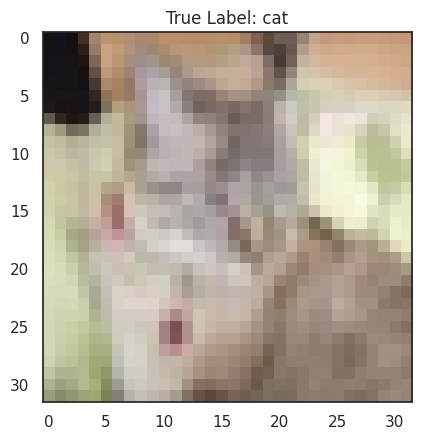

adam: bird
adahessian: bird
sgd: bird


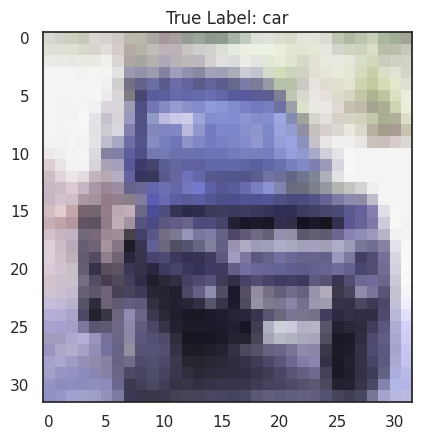

adam: car
adahessian: car
sgd: car


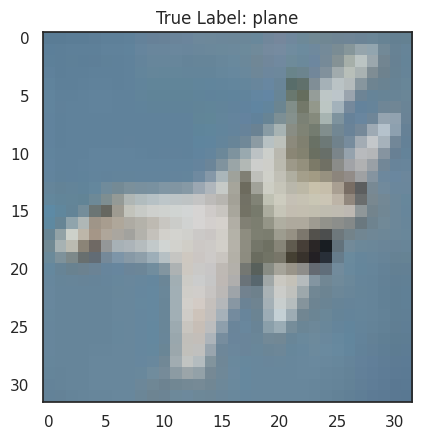

adam: ship
adahessian: ship
sgd: ship


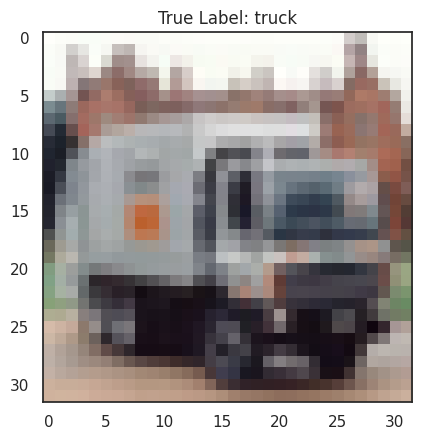

adam: truck
adahessian: truck
sgd: truck


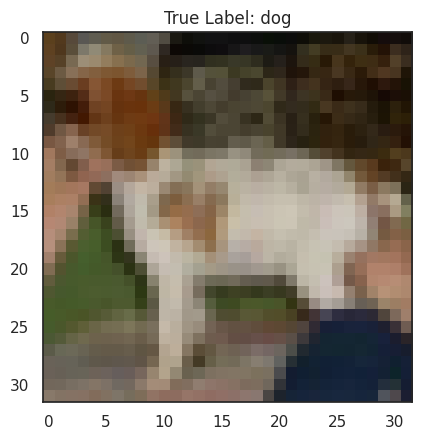

adam: deer
adahessian: car
sgd: car


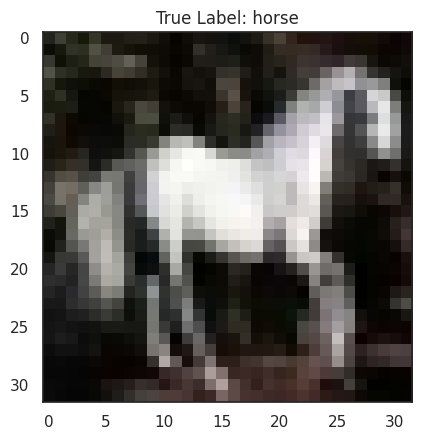

adam: horse
adahessian: car
sgd: car


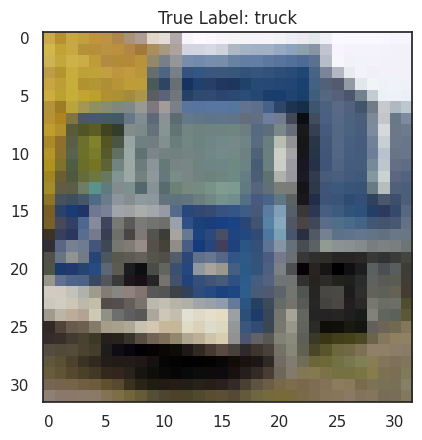

adam: truck
adahessian: truck
sgd: truck


In [13]:
def predicoes(model, images):
  test_output = model(images)
  pred_y = torch.max(test_output, 1)[1].data.squeeze()
  return pred_y

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


sns.set_theme(style="white", palette=None)
for images, labels in loaders['test']:
            preds_adam = predicoes(adam_cnn, images)
            preds_adahessian = predicoes(adahessian_cnn, images)
            preds_sgd = predicoes(sgd_cnn, images)
            i=0
            img_lab = list(zip(images,labels))[:15]
            for image, label in img_lab:
              plt.title(f'True Label: {classes[label.item()]}')
              plt.imshow(image.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)  # Denormalize and plot image
              plt.show()
              print(f'adam: {classes[preds_adam[i].item()]}')
              print(f'adahessian: {classes[preds_adahessian[i].item()]}')
              print(f'sgd: {classes[preds_sgd[i].item()]}')
              i+=1
            break

#Matriz de Confusão

In [14]:
!pip install pretty-confusion-matrix
from pretty_confusion_matrix import pp_matrix_from_data

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 14.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.1
    Uninstalling seaborn-0.13.1:
      Successfully uninstalled seaborn-0.13.1


<Figure size 1000x1000 with 0 Axes>

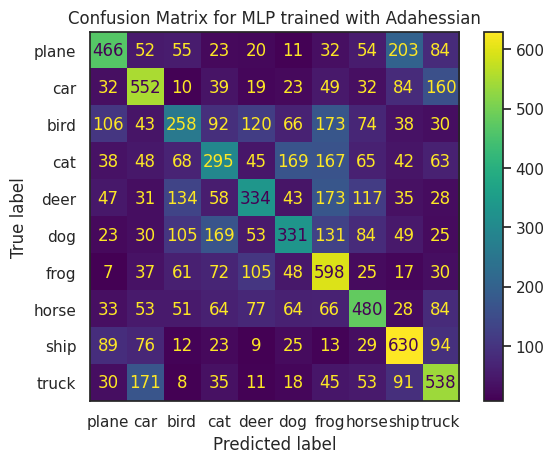

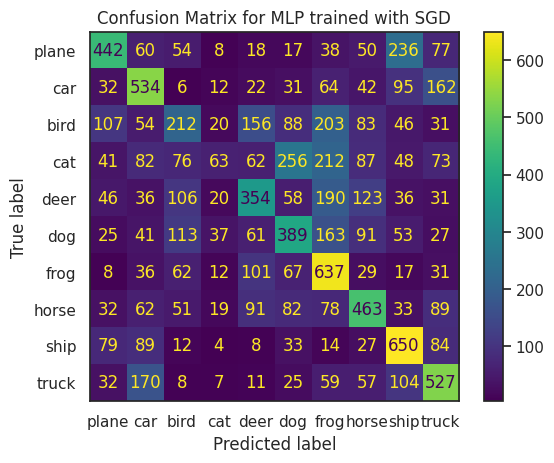

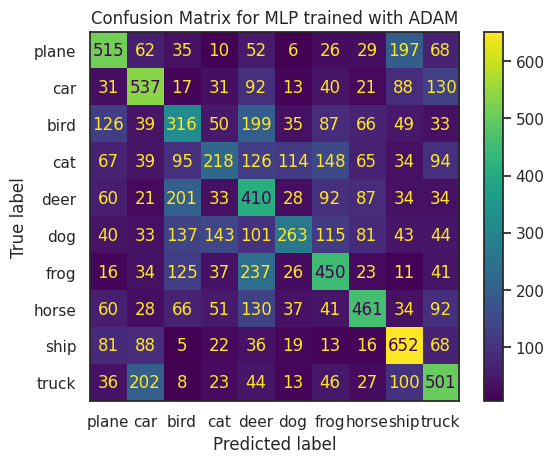

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
plt.figure(figsize=(10, 10))
for model_name, net in [('Adahessian',adahessian_cnn), ('SGD', sgd_cnn), ('ADAM', adam_cnn)]:
  y_pred = []
  y_true = []
  # iterate over test data
  for inputs, labels in loaders['test']:
          output = net(inputs) # Feed Network

          #
          output = (torch.max(torch.exp(output), 1)[1]).data.numpy()
          y_pred.extend(output) # Save Prediction

          labels = labels.data.cpu().numpy()
          y_true.extend(labels) # Save Truth

  # Build confusion matrix
  cm = confusion_matrix(y_true, y_pred)
  disp = ConfusionMatrixDisplay(cm)
  disp.plot()
  disp.ax_.set_title(f'Confusion Matrix for MLP trained with {model_name}')
  disp.ax_.xaxis.set_ticklabels(classes); disp.ax_.yaxis.set_ticklabels(classes);
  disp.ax_.autoscale()



Adahessian


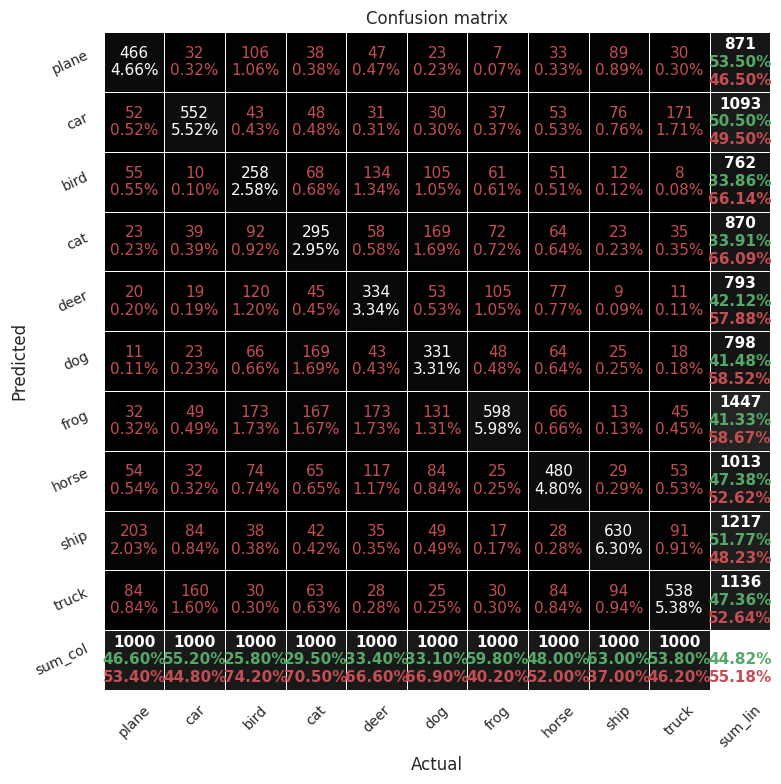

SGD


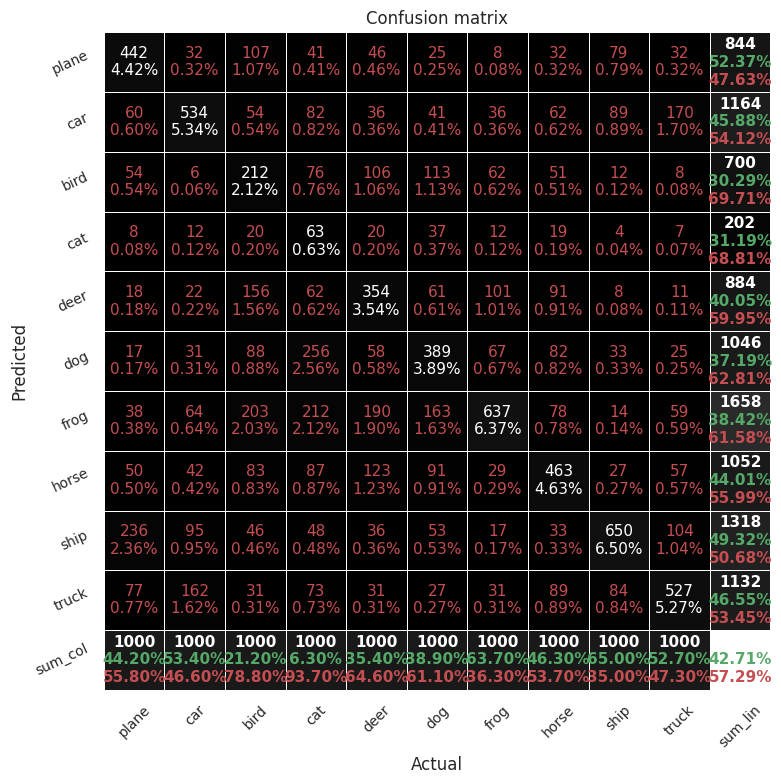

ADAM


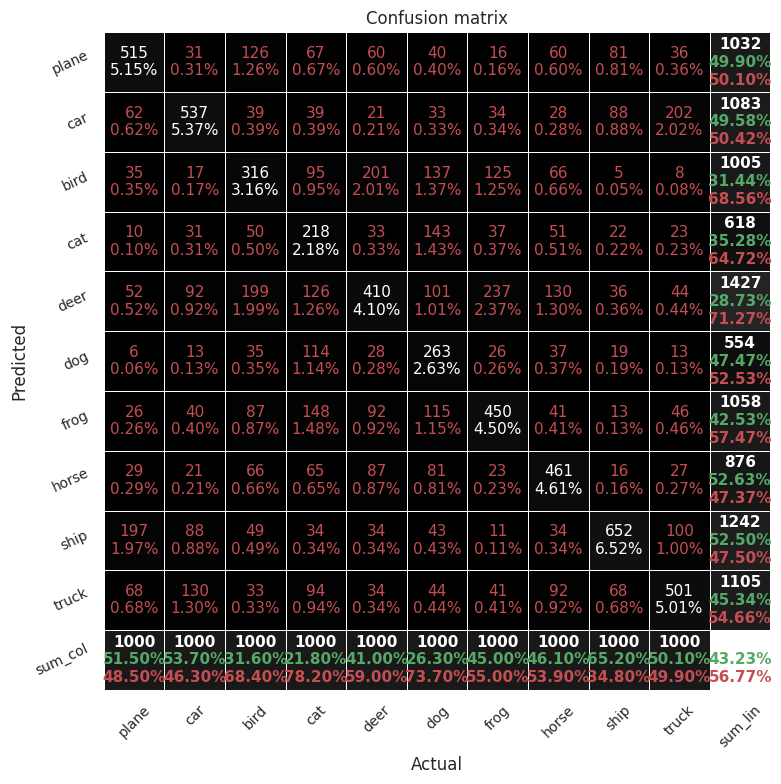

In [16]:
for model_name, net in [('Adahessian',adahessian_cnn), ('SGD', sgd_cnn), ('ADAM', adam_cnn)]:
  y_pred = []
  y_true = []
  # iterate over test data
  for inputs, labels in loaders['test']:
          output = net(inputs) # Feed Network

          #
          output = (torch.max(torch.exp(output), 1)[1]).data.numpy()
          y_pred.extend(output) # Save Prediction

          labels = labels.data.cpu().numpy()
          y_true.extend(labels) # Save Truth

  # Build confusion matrix
  print(model_name)
  pp_matrix_from_data(y_true, y_pred, columns=classes, cmap='gray')




In [17]:
from matplotlib import colormaps
list(colormaps)

['magma',
 'inferno',
 'plasma',
 'viridis',
 'cividis',
 'twilight',
 'twilight_shifted',
 'turbo',
 'Blues',
 'BrBG',
 'BuGn',
 'BuPu',
 'CMRmap',
 'GnBu',
 'Greens',
 'Greys',
 'OrRd',
 'Oranges',
 'PRGn',
 'PiYG',
 'PuBu',
 'PuBuGn',
 'PuOr',
 'PuRd',
 'Purples',
 'RdBu',
 'RdGy',
 'RdPu',
 'RdYlBu',
 'RdYlGn',
 'Reds',
 'Spectral',
 'Wistia',
 'YlGn',
 'YlGnBu',
 'YlOrBr',
 'YlOrRd',
 'afmhot',
 'autumn',
 'binary',
 'bone',
 'brg',
 'bwr',
 'cool',
 'coolwarm',
 'copper',
 'cubehelix',
 'flag',
 'gist_earth',
 'gist_gray',
 'gist_heat',
 'gist_ncar',
 'gist_rainbow',
 'gist_stern',
 'gist_yarg',
 'gnuplot',
 'gnuplot2',
 'gray',
 'hot',
 'hsv',
 'jet',
 'nipy_spectral',
 'ocean',
 'pink',
 'prism',
 'rainbow',
 'seismic',
 'spring',
 'summer',
 'terrain',
 'winter',
 'Accent',
 'Dark2',
 'Paired',
 'Pastel1',
 'Pastel2',
 'Set1',
 'Set2',
 'Set3',
 'tab10',
 'tab20',
 'tab20b',
 'tab20c',
 'magma_r',
 'inferno_r',
 'plasma_r',
 'viridis_r',
 'cividis_r',
 'twilight_r',
 'twilight